In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/MuraDataset')

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator, load_img
# from keras_preprocessing.image import ImageDataGenerator,load_img
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras import layers
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint,EarlyStopping

from sklearn.model_selection import train_test_split

In [4]:
datasetpath = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/'
# datasetpath = './MURA-v1.1/'

filepath = '/content/drive/MyDrive/MuraDataset/'
# filepath = './'

In [5]:
os.listdir(datasetpath)

['train_labeled_studies.csv',
 'valid_labeled_studies.csv',
 'train_image_paths.csv',
 'valid_image_paths.csv',
 'train_images_display_copy.csv',
 'train_images_display.csv',
 'valid',
 'train']

In [6]:
# Train set studies with labels
df=pd.read_csv(datasetpath+'train_labeled_studies.csv', names=['Train_Image','Train_Label'])

In [7]:
df.head()

,Train_Image,Train_Label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [8]:
# Adding labels to individual images in train set
df1=pd.read_csv(datasetpath+'train_image_paths.csv', names=['Train_Image'])
df1 = df1[df1['Train_Image'].str.split('/').str[2]== 'XR_HAND']
names=df1['Train_Image'].values


In [9]:
train_labels=[]

for i in names:
    if ('positive' in i):
        train_labels.append('1')
    elif('negative' in i):
        train_labels.append('0')

train_labels = np.array(train_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df1.insert(1, 'Train_Label', train_labels)

In [10]:
print(train_labels)

['1' '1' '1' ... '0' '0' '0']


In [11]:
df1.head()

,Train_Image,Train_Label
31265,MURA-v1.1/train/XR_HAND/patient09734/study1_po...,1
31266,MURA-v1.1/train/XR_HAND/patient09734/study1_po...,1
31267,MURA-v1.1/train/XR_HAND/patient09734/study1_po...,1
31268,MURA-v1.1/train/XR_HAND/patient09735/study1_po...,1
31269,MURA-v1.1/train/XR_HAND/patient09735/study1_po...,1


In [12]:
df1.shape

(5543, 2)

In [13]:
df1['Train_Image'] = filepath + df1['Train_Image']

In [14]:
df1.to_csv('Train_set.csv', index=False)

In [15]:
#Validation set studies with labels
df_valid=pd.read_csv(datasetpath+'valid_labeled_studies.csv', names=['Valid_Image','Valid_Label'])

In [16]:
df_valid.head()

,Valid_Image,Valid_Label
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [17]:
# Adding labels to individual images in validation set
df_valid1=pd.read_csv(datasetpath+'valid_image_paths.csv', names=['Valid_Image'])
df_valid1 = df_valid1[df_valid1['Valid_Image'].str.split('/').str[2]== 'XR_HAND']
names=df_valid1['Valid_Image'].values
valid_labels=[]

for i in names:
  if ('positive' in i):
    valid_labels.append('1')
  elif('negative' in i):
    valid_labels.append('0')

valid_labels = np.array(valid_labels)
#labels = pd.DataFrame(labels, columns=['Image', 'Label'])
df_valid1.insert(1, 'Valid_Label', valid_labels)
df_valid1.to_csv('Valid_set.csv', index=False)

In [18]:
df_valid1.head()

,Valid_Image,Valid_Label
960,MURA-v1.1/valid/XR_HAND/patient11497/study1_po...,1
961,MURA-v1.1/valid/XR_HAND/patient11497/study1_po...,1
962,MURA-v1.1/valid/XR_HAND/patient11497/study1_po...,1
963,MURA-v1.1/valid/XR_HAND/patient11498/study1_po...,1
964,MURA-v1.1/valid/XR_HAND/patient11498/study1_po...,1


In [19]:
df_valid1.shape

(460, 2)

In [20]:
df_valid1['Valid_Image'] = filepath + df_valid1['Valid_Image']
df_valid1.to_csv('Valid_set.csv', index=False)

In [21]:
# Read Training and Validation .csv files
train_df = pd.read_csv("./Train_set.csv", dtype=str)
valid_df = pd.read_csv("./Valid_set.csv", dtype=str)

In [22]:
print(len(train_df))
print(len(valid_df))

5543
460


In [23]:
# # shuffle the DataFrame rows
# train_df = train_df.sample(frac = 1)

In [24]:
train_df_part = train_df[:4000]
print(len(train_df_part))

4000


In [25]:
# train_df_part.head()

In [26]:
train_data, test_data = train_test_split(train_df_part, test_size=0.1,random_state=13,stratify = train_df_part['Train_Label'])

In [27]:
train_samples = pd.DataFrame(train_data)
test_samples = pd.DataFrame(test_data)

In [28]:
print(len(train_samples))
print(len(test_samples))

3600
400


In [29]:
# train_dir = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_HUMERUS/data/train'
# test_dir = '/content/drive/MyDrive/MuraDataset/MURA-v1.1/train/XR_HUMERUS/data/val'
# img_width = 300
# img_height = 300
# batch_size = 16

In [30]:
import keras

def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

In [31]:
# train_x1 = train_samples[train_samples['Train_Label'] == '0']
# train_100 = train_x1.iloc[:150,:]

# train_x2 = train_samples[train_samples['Train_Label'] == '1']
# train_x2_100 = train_x2.iloc[:150,:]

# train_200 = train_100.append(train_x2_100)
# print(len(train_200))

In [32]:
# valid_x1 = test_samples[test_samples['Train_Label'] == '0']
# test_100 = valid_x1.iloc[:300,:]

# valid_x2 = test_samples[test_samples['Train_Label'] == '1']
# test_x2_100 = valid_x2.iloc[:300,:]

# test_200 = test_100.append(test_x2_100)
# print(len(test_200))

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

In [34]:
# Image Preprocessing
train_generator = train_datagen.flow_from_dataframe(dataframe=train_samples, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 3600 validated image filenames belonging to 2 classes.


In [35]:
test_generator = valid_datagen.flow_from_dataframe(dataframe=test_samples, directory=None,
                                              x_col="Train_Image", y_col="Train_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 400 validated image filenames belonging to 2 classes.


In [36]:
valid_generator = valid_datagen.flow_from_dataframe(dataframe=valid_df,directory=None,
                                              x_col="Valid_Image", y_col="Valid_Label",
                                              target_size=(300,300), class_mode="binary",
                                              batch_size=16, shuffle=True)

Found 460 validated image filenames belonging to 2 classes.


In [37]:
# Import DenseNet169 pre-trained model
dense_model = DenseNet169(include_top=True, weights='imagenet',pooling = 'avg')

In [38]:
dense_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [39]:
# Import DenseNet169 pre-trained model
dense_model = DenseNet169(include_top=False, weights='imagenet',pooling = 'avg')

In [40]:
#Freeze the layers
dense_model.trainable = False
# Compile the model
for idx,layer in enumerate(dense_model.layers):
    layer_name = layer.name
    print(layer_name)
    if '_' in layer_name:
        block_name = layer_name.split('_')[1]
        print(block_name)
        if layer_name.split('_')[1] == 'block32':
            print(idx)

input_2
2
zero_padding2d_2
padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_3
padding2d
pool1
conv2_block1_0_bn
block1
conv2_block1_0_relu
block1
conv2_block1_1_conv
block1
conv2_block1_1_bn
block1
conv2_block1_1_relu
block1
conv2_block1_2_conv
block1
conv2_block1_concat
block1
conv2_block2_0_bn
block2
conv2_block2_0_relu
block2
conv2_block2_1_conv
block2
conv2_block2_1_bn
block2
conv2_block2_1_relu
block2
conv2_block2_2_conv
block2
conv2_block2_concat
block2
conv2_block3_0_bn
block3
conv2_block3_0_relu
block3
conv2_block3_1_conv
block3
conv2_block3_1_bn
block3
conv2_block3_1_relu
block3
conv2_block3_2_conv
block3
conv2_block3_concat
block3
conv2_block4_0_bn
block4
conv2_block4_0_relu
block4
conv2_block4_1_conv
block4
conv2_block4_1_bn
block4
conv2_block4_1_relu
block4
conv2_block4_2_conv
block4
conv2_block4_concat
block4
conv2_block5_0_bn
block5
conv2_block5_0_relu
block5
conv2_block5_1_conv
block5
conv2_block5_1_bn
block5
conv2_block5_1_relu
block5
conv2_block5_2_conv
block5
c

In [41]:
for layer in dense_model.layers[586:]:
    layer.trainable = True

    
for layer in dense_model.layers:
    print(layer,layer.trainable)      
   

<keras.engine.input_layer.InputLayer object at 0x7f0bd17d8e10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f0c2e254b50> False
<keras.layers.convolutional.Conv2D object at 0x7f0c2e87c3d0> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c2e352b10> False
<keras.layers.core.Activation object at 0x7f0bd16fa290> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f0c2e3da310> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0c2e408590> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c20034110> False
<keras.layers.core.Activation object at 0x7f0be2185590> False
<keras.layers.convolutional.Conv2D object at 0x7f0be2191c50> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c200ce350> False
<keras.layers.core.Activation object at 0x7f0c2e1cce90> False
<keras.layers.convolutional.Conv2D object at 0x7f0c2e1bcf90> False
<keras.layers.merge.Concatenate object at 0x7f0c200cebd0> False
<keras.layers.norma

In [42]:
predictions = Dense(1, activation='sigmoid')(dense_model.layers[-1].output)
model = Model(inputs=dense_model.input, outputs=predictions)

model.compile(optimizer = Adam(lr=0.0001), loss=dyn_weighted_bincrossentropy, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [43]:
for layer in model.layers:
    print(layer,layer.trainable)   

<keras.engine.input_layer.InputLayer object at 0x7f0bd17d8e10> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f0c2e254b50> False
<keras.layers.convolutional.Conv2D object at 0x7f0c2e87c3d0> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c2e352b10> False
<keras.layers.core.Activation object at 0x7f0bd16fa290> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f0c2e3da310> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0c2e408590> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c20034110> False
<keras.layers.core.Activation object at 0x7f0be2185590> False
<keras.layers.convolutional.Conv2D object at 0x7f0be2191c50> False
<keras.layers.normalization_v2.BatchNormalization object at 0x7f0c200ce350> False
<keras.layers.core.Activation object at 0x7f0c2e1cce90> False
<keras.layers.convolutional.Conv2D object at 0x7f0c2e1bcf90> False
<keras.layers.merge.Concatenate object at 0x7f0c200cebd0> False
<keras.layers.norma

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [45]:
# Number of train and validation steps
if train_generator.n%train_generator.batch_size == 0:
    train_steps=train_generator.n//train_generator.batch_size
else:
    train_steps=train_generator.n//train_generator.batch_size+1
    
if test_generator.n%test_generator.batch_size == 0: 
    test_steps=test_generator.n//test_generator.batch_size
else:    
    test_steps=test_generator.n//test_generator.batch_size+1
print(train_steps)
print(test_steps)

225
25


In [46]:
finalfilepath = filepath+'bestmodel/handmodel-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.h5'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpoint = ModelCheckpoint(finalfilepath, monitor='val_loss', save_best_only=False, save_weights_only= True,verbose=1, mode='auto')


In [47]:
# Fit the model
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_steps,
                    validation_data=test_generator,
                    validation_steps=test_steps,
                    epochs=15,
                    callbacks=[checkpoint,es])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
225/225 [==============================] - 147s 436ms/step - loss: 0.3153 - accuracy: 0.5517 - val_loss: 0.3735 - val_accuracy: 0.5300

Epoch 00001: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/handmodel-00001-0.30737-0.57972-0.37345-0.53000.h5
Epoch 2/15
225/225 [==============================] - 86s 381ms/step - loss: 0.2843 - accuracy: 0.6517 - val_loss: 0.2756 - val_accuracy: 0.7175

Epoch 00002: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/handmodel-00002-0.28119-0.65917-0.27563-0.71750.h5
Epoch 3/15
225/225 [==============================] - 85s 379ms/step - loss: 0.2685 - accuracy: 0.6991 - val_loss: 0.2808 - val_accuracy: 0.6500

Epoch 00003: saving model to /content/drive/MyDrive/MuraDataset/bestmodel/handmodel-00003-0.26672-0.69194-0.28076-0.65000.h5
Epoch 4/15
225/225 [==============================] - 85s 377ms/step - loss: 0.2562 - accuracy: 0.7001 - val_loss: 0.2586 - val_accuracy: 0.6975

Epoch 00004: saving model to /content/dr

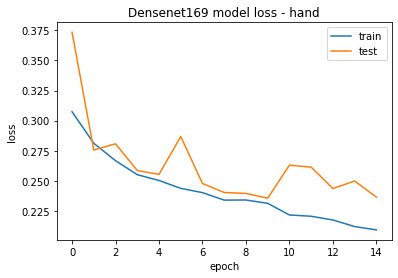

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Densenet169 model loss - hand')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(filepath+'denseloss_hand',dpi = 300)
plt.show()

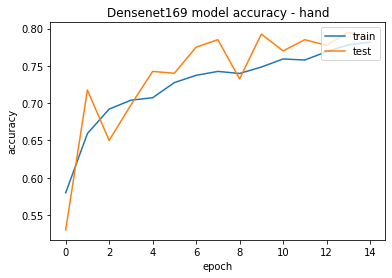

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Densenet169 model accuracy - hand')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(filepath+'denseacc_hand',dpi = 300)
plt.show()

In [50]:
import cv2
def get_testdata():
    image_data = []
    x_data = []
    y_data = []
    for index, row in test_samples.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [51]:
testx1,testy1 = get_testdata()
print(testx1.shape)
print(testy1.shape)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


(400, 300, 300, 3)
(400,)


In [52]:
testy1 = list(map(int, testy1))

In [53]:
# predict probabilities for test set
y_probs = model.predict(testx1 , verbose=0)
# predict crisp classes for test set
y_classes = (y_probs > 0.5).astype('int32')


In [54]:
# reduce to 1d array
y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

In [55]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [56]:
# accuracy: (tp + tn) / (p + n)
test_accuracy = accuracy_score(testy1, y_classes)
print('Accuracy: %f' % test_accuracy)
# precision tp / (tp + fp)
test_precision = precision_score(testy1, y_classes)
print('Precision: %f' % test_precision)
# recall: tp / (tp + fn)
test_recall = recall_score(testy1, y_classes)
print('Recall: %f' % test_recall)
# f1: 2 tp / (2 tp + fp + fn)
test_f1 = f1_score(testy1, y_classes)
print('F1 score: %f' % test_f1)
# kappa
test_kappa = cohen_kappa_score(testy1, y_classes)
print('Cohens kappa: %f' % test_kappa)
# ROC AUC
test_auc = roc_auc_score(testy1, y_probs)
print('ROC AUC: %f' % test_auc)
# confusion matrix
test_matrix = confusion_matrix(testy1, y_classes)
print(test_matrix)

Accuracy: 0.772500
Precision: 0.735537
Recall: 0.601351
F1 score: 0.661710
Cohens kappa: 0.492923
ROC AUC: 0.829526
[[220  32]
 [ 59  89]]


In [57]:
from sklearn.metrics import roc_curve
fpr_test, tpr_test, thresholds_test = roc_curve(testy1, y_probs)

In [58]:
from sklearn.metrics import auc
auc_test = auc(fpr_test, tpr_test)

In [59]:
from sklearn.metrics import precision_recall_curve
test_precision, test_recall, thresholds = precision_recall_curve(testy1, y_probs)

In [60]:
# plot the precision-recall curves
no_skill = len(testy1[testy1==1]) / len(testy1)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(test_recall, test_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

TypeError: ignored

In [ ]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='(AUC = {:.3f})'.format(auc_test))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('BaselineApproach - ROC curve for testdata(Humerus)',fontsize=15)
plt.legend(loc='best')
plt.show()

In [ ]:
import cv2
def get_data():
    image_data = []
    x_data = []
    y_data = []
    for index, row in valid_df.iterrows():
        image_data_temp = cv2.imread(row[0],cv2.IMREAD_COLOR)                 # Read Image as numbers
        image_temp_resize = cv2.resize(image_data_temp,(300,300))
        image_data.append([image_temp_resize,row[1]])
    data = np.asanyarray(image_data)    

    for x in data:
        x_data.append(x[0])        # Get the X_Data
        y_data.append(x[1])        # get the label
              
    X_Data = np.asarray(x_data) / (255.0)      # Normalize Data
    Y_Data = np.asarray(y_data)
        
            # reshape x_Data

    X_Data = X_Data.reshape(-1, 300, 300, 3)

    return X_Data,Y_Data

In [ ]:
testX,testY = get_data()
testY = list(map(int, testY))


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(testX , verbose=0)
# predict crisp classes for test set
yhat_classes = (yhat_probs > 0.5).astype('int32')


In [ ]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

In [ ]:
print(yhat_probs)

In [ ]:
print(yhat_classes)

In [ ]:
print(testY)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)

In [ ]:
# kappa
kappa = cohen_kappa_score(testY, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testY, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testY, yhat_classes)
print(matrix)

In [ ]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, yhat_probs)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
plt.figure(1,figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate',fontsize=13)
plt.ylabel('True positive rate',fontsize=13)
plt.title('Baseline Approach - ROC curve for Validationdata(Humerus)',fontsize=15)
plt.legend(loc='best')
plt.show()
